In [86]:
import numpy as np
import numpy.random as npr

from scipy.special import gammaln

import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [87]:
# Define some helper functions
def normal_pdf(x, m, s):
    return 1./np.sqrt(2*np.pi*s**2) * np.exp(-1./2 * (x-m)**2 / s**2)

def normal_logpdf(x, m, s):
    return -1.2 * np.log(2*np.pi*s**2)  -1./2 * (x-m)**2 / s**2

def dirichlet_logpdf(pi, alpha):
    # Make sure alpha is the same shape as pi,
    # namely, a length K vector.
    assert pi.ndim == 1
    K = pi.shape[0]
    alpha = alpha * np.ones(K)
    return gammaln(np.sum(alpha)) - np.sum(gammaln(alpha)) + np.sum((alpha-1) * np.log(pi))


# Notation

$K$ clusters

$N$ datapoints

$\mu_0, \eta^2_0$ mean and variance of the cluster centers

$\alpha \in \mathbb{R}_+^K$ pseudocounts in the Dirichlet prior

$\mathbf{\pi} \in [0,1]^K$ pi for each class

$\mu_k \in \mathbb{R}$ Mean of the $k$-th cluster

$z_n \in \{1, ..., K\}$  label for the $n$-th datapoint

$x_n \in \mathbb{R}$ value of the $n$-th datapoint

# Model

$\pi \sim Dir(\alpha)$  Dirichlet distributed weights

$\mu_k \sim N(\mu_0, \eta_0^2)$ is the center of the $k$-th cluster

$z_n \sim \mathbf{\pi}$ 


$x_n \sim N(\mu_{z_n}, \sigma^2)$

# Log probability
$p(\{x_n, z_n\}_{n=1}^N, \{\mu_k\}_{k=1}^K, \pi \, | \, \alpha \mu_0, \eta_0^2, \sigma^2)$

$= \prod_n p(x_n | \mu_{z_n}, \sigma^2) \times p(z_n | \pi)  \times \prod_{k} p(\mu_k | \alpha, \mu_0, \eta_0^2) \times Dir(\pi \, | \, \alpha)$

$=\prod_n N(x_n \, | \, \mu_{z_n}, \sigma^2) \times  \pi_{z_n} \times \prod_{k} N(\mu_k | \mu_0, \eta_0^2) \times Dir(\pi \, | \, \alpha)$


In [88]:
def log_probability(X, Z, mus, pi, alpha, mu0, eta0sq, sigmasq):
    N, K = X.shape[0], mus.shape[0]
    lp = 0
    
    # per-datapoint likelihood
    for n in range(N):
        lp += normal_logpdf(X[n], mus[Z[n]], sigmasq)
        lp += np.log(pi[Z[n]])
        
    # per-cluster probability
    for k in range(K):
        lp += normal_logpdf(mus[k], mu0, eta0sq)
        
    # weights probability
    lp += dirichlet_logpdf(pi, alpha)
    
    return lp

# Bayesian Inference

In [89]:
# What's unknown?
# For each class k:
#   - mean:    \mu_k
#   - weight:  w_k
#
# For each data point:
#   - label:   z_n

# Hyperparameters
K = 2      # Number of classes
mu0 = 0.0   # mean of the mus
eta0sq = 1.0   # variance of the mus
sigmasq = 1.0  # variance of the observations, X[n]
alpha = 1. * np.ones(K)

/Users/scott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


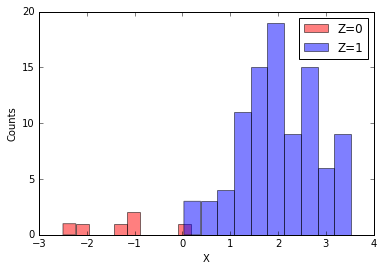

In [90]:
# Try it out!
sigmasq = 1.0
pi_true = np.array([0.1, 0.9])
mus_true = np.array([-2.0, +2.0])

N = 100
Z_true, X = sample_gmm(N, pi_true, mus_true, sigmasq)

plt.figure(figsize=(6,4))
plt.hist(X[Z_true==0], 10, color='r', alpha=0.5, label="Z=0")
plt.hist(X[Z_true==1], 10, color='b', alpha=0.5, label="Z=1")
plt.xlabel("X")
plt.ylabel("Counts")
plt.legend(loc="upper right")


In [91]:
N_iter = 500

# Initialize the state of the algorithm
mus = np.random.normal(mu0 * np.ones(K), np.sqrt(eta0sq) * np.ones(K))
pi = np.array([0.5, 0.5])
Z = np.random.choice(K, size=N, p=pi)

samples = []
for itr in tqdm.tqdm(range(N_iter)):
    # 1. Calculate the log probability under the current parameters
    lp = log_probability(X, Z, mus, pi, alpha, mu0, eta0sq, sigmasq)
        
    # 2. Sample labels given the mus and the pi
    for n in range(N):
        # Since we know X[n], this should tell us whether
        # class zero or class one is more likely
        pn = np.zeros(K)
        for k in range(K):
            # What's the probability that X[n] came from 
            # class k?  Intuitively...
            # pn[k] \propto N(X[n] | mus[k], stds) * pi[k]
            # 
            # N(x | m, s) = 1/sqrt(2*pi*s**2) * exp(-1/2 (x-m)**2 / s**2)
            pn[k] = normal_pdf(X[n], mus[k], np.sqrt(sigmasq))
            pn[k] *= pi[k]
            
        # Normalize pn so that it sums to one
        pn = pn / np.sum(pn)
        
        # Now we can sample Z[n] from its *conditional* 
        # distribution given X[n], mus, pi
        Z[n] = np.random.choice(K, p=pn)
    
    # Compute how many datapoints are in each class
    M = np.array([np.sum(Z==k) for k in range(K)])
    
    # 3. Sample mus given the labels
    for k in range(K):
        # Compute the conditional distribution of mus[k]
        # given X, Z, and the prior, mu0, eta0sq
        # p(mus[k]) \propto 
        #     \prod_n N(X[n] | Z[n]==k, mus[k], std) * N(mus[k] | mu0, eta0sq)
        # 
        # TODO: Derive the mean and sigmasqiance of the conditional distribution
        # 
        # Trust me... as I write down the mean and sigmasqiance of mus[k] 
        # under the conditional distribution. 
        vk = 1./(1./eta0sq + M[k]/sigmasq)
        mk = vk * (mu0/eta0sq + X[Z==k].sum() / sigmasq)
        
        # Sample from the conditional normal distribution
        mus[k] = np.random.normal(mk, np.sqrt(vk))
        
        # Note that when eta0sq goes to infinity, vk goes to std**2 / Nk
        # and mk goes to X[Z==k].mean(). This shows why it makes sense
        # to just set mus[k] as we did before:
        # mus[k] = X[Z==k].mean() 
    
    # 4. Sample pi given the labels
    # Since pi has a Dirichlet prior distribution, and this is conjugate 
    # with the discrete labels, the conditional, or "posterior" distribution
    # of pi is Dirichlet as well.
    pi = np.random.dirichlet(alpha + M)
        
    # 5. Save this iteration's state
    samples.append((lp, mus.copy(), pi.copy()))

lp_smpls = np.array([s[0] for s in samples])
mus_smpls = np.array([s[1] for s in samples])
pi_smpls = np.array([s[2] for s in samples])

100%|██████████| 500/500 [00:02<00:00, 233.30it/s]


/Users/scott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/scott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


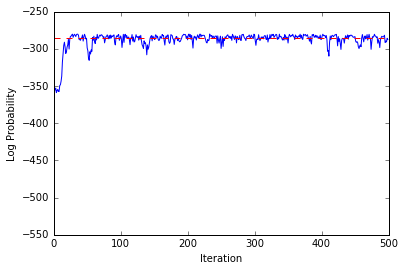

In [93]:
# Look at the log probability over iteration
lp_true = log_probability(X, Z_true, mus_true, pi_true, alpha, mu0, eta0sq, sigmasq)
plt.plot(lp_smpls)
plt.plot([0, N_iter], lp_true * np.ones(2), '--r')
plt.xlabel("Iteration")
plt.ylabel("Log Probability")

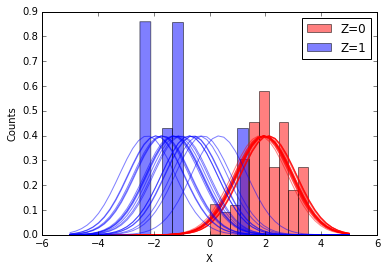

In [94]:
# So... let's look at mixture distributions
colors = ['r', 'b']
plt.figure(figsize=(6,4))
xx = np.linspace(-5,5)
for k in range(K):
    plt.hist(X[Z==k], 10, color=colors[k], alpha=0.5, 
         label="Z={}".format(k), normed=True)

    # Plot a few samples of the means
    for itr in range(N_iter-100, N_iter, 5):
        plt.plot(xx, normal_pdf(xx, mus_smpls[itr, k], np.sqrt(sigmasq)), 
                 color=colors[k], linewidth=1, alpha=0.5)
    
plt.xlabel("X")
plt.ylabel("Counts")
plt.legend(loc="upper right")

Notice that there is a lot more uncertainty for the class with fewer datapoints.

Num Z==0: 94
Num Z==1: 6
Num true Z==0: 6
Num true Z==1: 94


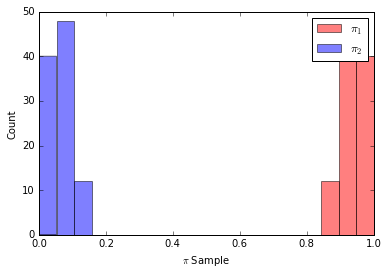

In [95]:
pi_bins = np.linspace(0.,1.,20)
plt.hist(pi_smpls[-100:,0], pi_bins, color='r', alpha=0.5, label="$\pi_1$")
plt.hist(pi_smpls[-100:,1], pi_bins, color='b', alpha=0.5, label="$\pi_2$")
plt.xlabel("$\pi$ Sample")
plt.ylabel("Count")
plt.legend(loc="upper right")

print("Num Z==0: {}".format((Z==0).sum()))
print("Num Z==1: {}".format((Z==1).sum()))

print("Num true Z==0: {}".format((Z_true==0).sum()))
print("Num true Z==1: {}".format((Z_true==1).sum()))


# Next Steps 
- Play with the parameters of the model and get a feel for how the prior affects the posterior distribution.
- "Objectify" the code